In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt  

In [ ]:
""" TRANSPOSING TIME SERIES FOR EASIER MANIPULATION """

"""# The name of the original CSV file
input_filename = 'Data/time_series.csv'

# The name of the new CSV file with the ID column added
output_filename = 'Data/time_series_T.csv'

# Read the original CSV file into a DataFrame
df = pd.read_csv(input_filename)

# Add an 'ID' column, which is a sequence of numbers starting from 1
#df.insert(0, 'ID', range(1, 1 + len(df)))
df=df.T

# Save the DataFrame with the new 'ID' column back to a new CSV file
df.to_csv(output_filename, index=False)"""


In [2]:
"print(df.columns)"

RangeIndex(start=0, stop=5766, step=1)


### Check If I have some constant values

In [2]:

df = pd.read_csv("Data/time_series_T.csv")
P =df.values

In [3]:

timeseries = np.nan_to_num(P, nan=0.0, posinf=0.0, neginf=0.0)

# Quickly check if there are any constant columns
if np.any(np.std(timeseries, axis=0) == 0):
    print("Dataset contains constant time series.")


### Just use a chunck of Data 

In [4]:

# Load your data here
# timeseries shape: [time x neuron]

# Select a subset of the data
num_neurons_subset = 500  # Choose how many neurons you want to include
time_start = 0  # Starting index for the time series
time_end = 1000  # Ending index for the time series 

timeseries_subset = P[time_start:time_end, :num_neurons_subset]


### Sliding window and corr features

In [6]:

def corrcoef(x):
    """Compute the Pearson correlation coefficient matrix with handling for constant time series.
        Method from stagin.
    
    """
    mean_x = np.mean(x, axis=1, keepdims=True)
    xm = x - mean_x
    c = np.dot(xm, xm.T)
    c /= x.shape[1] - 1
    d = np.diag(c)
    stddev = np.sqrt(d)
    
    # Prevent division by zero for constant time series
    # Set correlation for constant time series to 0 (or could use np.nan or another specified value)
    stddev[stddev == 0] = np.inf
    c /= stddev[:, None]
    c /= stddev[None, :]
    
    # Correct the diagonal (auto-correlation) to 1 for all neurons
    # This step is optional and depends on whether you want to keep self-correlation as 1 or not
    np.fill_diagonal(c, 1)
    
    c = np.clip(c, -1.0, 1.0)
    return c


def get_fc(timeseries, remove_self_loops=True):
    """Compute the FC matrix for a single window of the time series."""
    fc = corrcoef(timeseries)
    if remove_self_loops:
        np.fill_diagonal(fc, 0)
    return fc

def process_dynamic_fc(timeseries, window_size, window_stride, remove_self_loops=True):
    """Process dynamic functional connectivity for a single time series."""
    # Shape of timeseries expected: [time x node]
    num_windows = (timeseries.shape[0] - window_size) // window_stride + 1
    dynamic_fc = []

    for w_start in range(0, num_windows * window_stride, window_stride):
        windowed_timeseries = timeseries[w_start:w_start + window_size].T  # Transpose to [node x time] for correlation
        fc_matrix = get_fc(windowed_timeseries, remove_self_loops)
        dynamic_fc.append(fc_matrix)

    return np.array(dynamic_fc)

# Examlpe usage
#timeseries = np.random.rand(5000, 300)  # Simulated example data: 6000 timesteps, 5766 neurons
#df = pd.read_csv("Data/time_series_T.csv")

#P =df.values
window_size = 50  # Example window size
window_stride = 1  # Example window stride

dynamic_fc_matrices = process_dynamic_fc(timeseries_subset, window_size, window_stride)
print(dynamic_fc_matrices.shape)

print(dynamic_fc_matrices)

(951, 500, 500)
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00 -7.23750124e-01 ...  1.45527013e-01
   -6.68446025e-01 -2.45517313e-01]
  [ 0.00000000e+00 -7.23750124e-01  0.00000000e+00 ... -3.93540520e-01
    2.41041540e-01  2.16496702e-01]
  ...
  [ 0.00000000e+00  1.45527013e-01 -3.93540520e-01 ...  0.00000000e+00
   -2.48026141e-01 -9.77825164e-04]
  [ 0.00000000e+00 -6.68446025e-01  2.41041540e-01 ... -2.48026141e-01
    0.00000000e+00  9.57886521e-02]
  [ 0.00000000e+00 -2.45517313e-01  2.16496702e-01 ... -9.77825164e-04
    9.57886521e-02  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00 -7.32121723e-01 ...  1.31640379e-01
   -7.12975686e-01 -2.95680510e-01]
  [ 0.00000000e+00 -7.32121723e-01  0.00000000e+00 ... -4.04491631e-01
    2.77795945e-01  2.58232052e-01]
  ...
  [ 0.0

In [7]:
def convert_to_binary_adjacency(fc_matrices, percentile=70):
    """
    Convert FC matrices to binary adjacency matrices based on a percentile threshold.
    
    Parameters:
    - fc_matrices: An array of shape [num_windows, num_neurons, num_neurons] containing FC matrices.
    - percentile: The percentile to use as a threshold for determining connectivity (default is 70, for top 30-percentile).
    
    Returns:
    - adjacency_matrices: An array of the same shape as fc_matrices, but with binary values indicating connectivity.
    
    """
    adjacency_matrices = np.zeros_like(fc_matrices)
    
    for i, fc_matrix in enumerate(fc_matrices):
        # Calculate the threshold based on the specified percentile for each FC matrix
        threshold = np.percentile(fc_matrix, percentile)
        
        # Apply the threshold to convert the FC matrix to a binary adjacency matrix
        adjacency_matrix = np.where(fc_matrix >= threshold, 1, 0)
        
        # Optionally, remove self-loops by setting the diagonal to 0
        np.fill_diagonal(adjacency_matrix, 0)
        
        adjacency_matrices[i] = adjacency_matrix
        
    return adjacency_matrices

# Convert the dynamic FC matrices to binary adjacency matrices
binary_adjacency_matrices = convert_to_binary_adjacency(dynamic_fc_matrices)

print(binary_adjacency_matrices.shape)
binary_adjacency_matrices

(951, 500, 500)


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0.

### Visulize graphs for each time frame

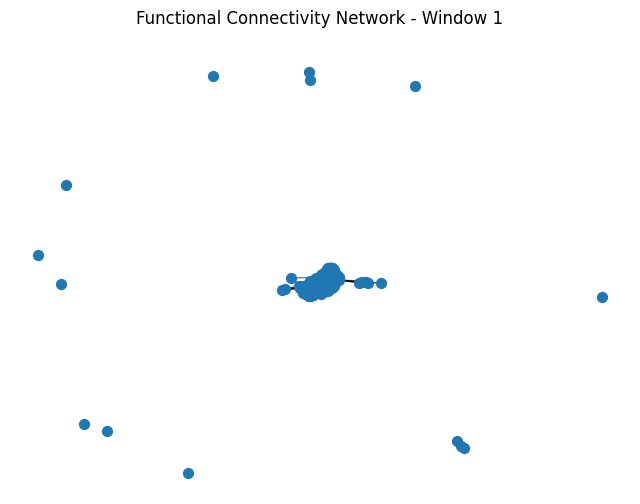

In [8]:


def visualize_graph(adj_matrix, ax, title="Functional Connectivity Network"):
    """
    Visualize a single graph from an adjacency matrix.
    
    Parameters:
    - adj_matrix: A binary adjacency matrix (numpy array) where 1 indicates a connection.
    - ax: matplotlib axis object to plot the graph.
    - title: Title for the graph.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix)
    
    # Draw the network
    pos = nx.spring_layout(G)  # Positions for all nodes using one of the layout options
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
    ax.set_title(title)
    ax.axis('off')

# Assuming `binary_adjacency_matrices` is your list/array of binary adjacency matrices
# Visualize the graph for the first time window as an example
fig, ax = plt.subplots(figsize=(8, 6))
visualize_graph(binary_adjacency_matrices[0], ax, title="Functional Connectivity Network - Window 1")

plt.show()


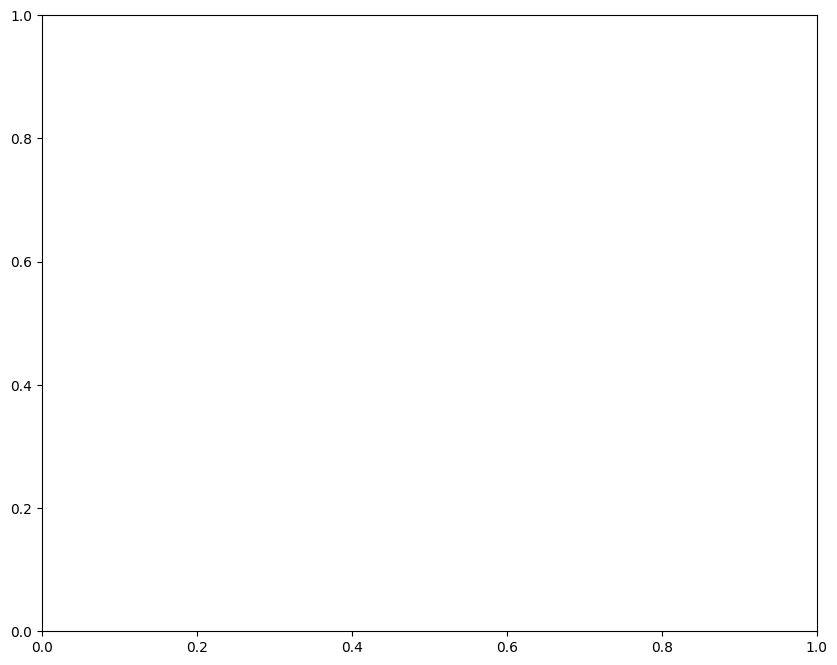

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation

# Helper function to update plot for each frame
def update(num, binary_adjacency_matrices, ax):
    ax.clear()
    G = nx.from_numpy_array(binary_adjacency_matrices[num])
    pos = nx.spring_layout(G, seed=42)  # Fixed seed for consistent layout
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=20, node_color="blue")
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
    ax.set_title(f"Functional Connectivity Network - Window {num+1}")
    ax.axis('off')

fig, ax = plt.subplots(figsize=(10, 8))

# Assuming `binary_adjacency_matrices` is a list of your binary adjacency matrices
ani = FuncAnimation(fig, update, frames=len(binary_adjacency_matrices), fargs=([binary_adjacency_matrices, ax]), interval=500, repeat=True)

plt.show()


In [ ]:
ani.save('dynamic_network.mp4', writer='ffmpeg')  # Save as MP4


### Create time embedding